In [1]:
# Importing libraries for data manipulation, statistical analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
# Import required libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, norm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')
# Suppress warnings for cleaner output
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)


In [2]:
# ============================================================================
# SECTION 1: DATA LOADING AND PREPROCESSING
# ============================================================================

print("\n[STEP 1] Loading and Preprocessing Data...")

# Load the dataset
df = pd.read_csv('online_retail_II.csv', encoding='ISO-8859-1')
print(f"✓ Dataset loaded successfully")
print(f"✓ Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Data quality assessment
print(f"\n📊 Data Quality Assessment:")
print(f"✓ Missing values: {df.isnull().sum().sum():,}")
print(f"✓ Duplicate transactions: {df.duplicated().sum():,}")
print(f"✓ Negative quantities: {(df['Quantity'] < 0).sum():,}")
print(f"✓ Unique customers: {df['Customer ID'].nunique():,}")

# Clean the dataset
df_clean = df.copy()
# Remove transactions with missing Customer ID
df_clean = df_clean.dropna(subset=['Customer ID'])
# Remove returns (negative quantities)
df_clean = df_clean[df_clean['Quantity'] > 0]
# Remove transactions with negative or zero prices
df_clean = df_clean[df_clean['Price'] > 0]
# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

print(f"\n✓ Clean dataset: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")



[STEP 1] Loading and Preprocessing Data...
✓ Dataset loaded successfully
✓ Shape: 1,067,371 rows × 8 columns

📊 Data Quality Assessment:
✓ Missing values: 247,389
✓ Duplicate transactions: 34,335
✓ Negative quantities: 22,950
✓ Unique customers: 5,942

✓ Clean dataset: 805,549 rows × 8 columns


In [3]:
df_clean.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [20]:
df_clean

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [12]:
# ============================================================================
# SECTION 2: EXPERIMENTAL DESIGN AND SAMPLE SIZE CALCULATION
# ============================================================================

print("\n[STEP 2] Experimental Design...")

# Define test parameters
BASELINE_CONVERSION_RATE = 0.12  # Industry benchmark: 12%
MINIMUM_DETECTABLE_EFFECT = 0.02  # 2 percentage points increase
SIGNIFICANCE_LEVEL = 0.05
STATISTICAL_POWER = 0.80
TEST_DURATION_DAYS = 21

print(f"🎯 Experimental Parameters:")
print(f"   • Baseline Conversion Rate: {BASELINE_CONVERSION_RATE:.1%}")
print(f"   • Minimum Detectable Effect: {MINIMUM_DETECTABLE_EFFECT:.1%}")
print(f"   • Significance Level (α): {SIGNIFICANCE_LEVEL}")
print(f"   • Statistical Power (1-β): {STATISTICAL_POWER}")
print(f"   • Test Duration: {TEST_DURATION_DAYS} days")


# Sample size calculation
def calculate_sample_size(p1, p2, alpha=0.05, power=0.8):
    """Calculate required sample size for proportion test"""
    effect_size = abs(p2 - p1) / np.sqrt(p1 * (1 - p1))
    power_analysis = TTestIndPower()
    n = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
    return int(np.ceil(n))


required_sample_size = calculate_sample_size(
    BASELINE_CONVERSION_RATE,
    BASELINE_CONVERSION_RATE + MINIMUM_DETECTABLE_EFFECT
)

print(f"\n📈 Power Analysis:")
print(f"   • Required sample size per group: {required_sample_size:,}")
print(f"   • Total sample size needed: {required_sample_size * 2:,}")


[STEP 2] Experimental Design...
🎯 Experimental Parameters:
   • Baseline Conversion Rate: 12.0%
   • Minimum Detectable Effect: 2.0%
   • Significance Level (α): 0.05
   • Statistical Power (1-β): 0.8
   • Test Duration: 21 days

📈 Power Analysis:
   • Required sample size per group: 4,146
   • Total sample size needed: 8,292


In [13]:
print("\n[STEP 3] Creating Test and Control Groups...")

# Create customer-level aggregations
customer_summary = df_clean.groupby('Customer ID').agg({
    'Invoice': 'nunique',  # Number of orders
    'Quantity': 'sum',     # Total items purchased
    'Price': lambda x: (x * df_clean.loc[x.index, 'Quantity']).sum(),  # Total revenue
    'InvoiceDate': ['min', 'max']
}).round(2)

customer_summary.columns = ['total_orders', 'total_items', 'total_revenue', 'first_purchase', 'last_purchase']
customer_summary = customer_summary.reset_index()

# Calculate customer lifetime value and other metrics
customer_summary['days_active'] = (customer_summary['last_purchase'] - customer_summary['first_purchase']).dt.days + 1
customer_summary['avg_order_value'] = customer_summary['total_revenue'] / customer_summary['total_orders']
customer_summary['clv'] = customer_summary['total_revenue']  # Simplified CLV

# Filter active customers (at least 2 orders for meaningful analysis)
active_customers = customer_summary[customer_summary['total_orders'] >= 2].copy()

print(f"✓ Active customers for analysis: {len(active_customers):,}")
print(f"✓ Average orders per customer: {active_customers['total_orders'].mean():.1f}")
print(f"✓ Average order value: ${active_customers['avg_order_value'].mean():.2f}")

# Randomly assign customers to test and control groups
np.random.seed(42)  # For reproducibility
active_customers['group'] = np.random.choice(['control', 'treatment'], size=len(active_customers), p=[0.5, 0.5])

# Simulate the effect of free shipping
# Treatment group gets improved metrics to simulate free shipping impact
treatment_customers = active_customers[active_customers['group'] == 'treatment'].copy()
control_customers = active_customers[active_customers['group'] == 'control'].copy()

# Simulate treatment effect (free shipping increases conversion and AOV)
np.random.seed(123)
treatment_customers['total_orders'] = treatment_customers['total_orders'] + np.random.poisson(0.3, len(treatment_customers))
treatment_customers['avg_order_value'] = treatment_customers['avg_order_value'] * np.random.normal(1.08, 0.05, len(treatment_customers))
treatment_customers['total_revenue'] = treatment_customers['total_orders'] * treatment_customers['avg_order_value']
treatment_customers['clv'] = treatment_customers['total_revenue']

# Combine groups
test_data = pd.concat([control_customers, treatment_customers], ignore_index=True)

print(f"\n📊 Group Distribution:")
print(f"   • Control group: {len(control_customers):,} customers")
print(f"   • Treatment group: {len(treatment_customers):,} customers")


[STEP 3] Creating Test and Control Groups...
✓ Active customers for analysis: 4,255
✓ Average orders per customer: 8.3
✓ Average order value: $407.61

📊 Group Distribution:
   • Control group: 2,122 customers
   • Treatment group: 2,133 customers



[STEP 4] Exploratory Data Analysis...


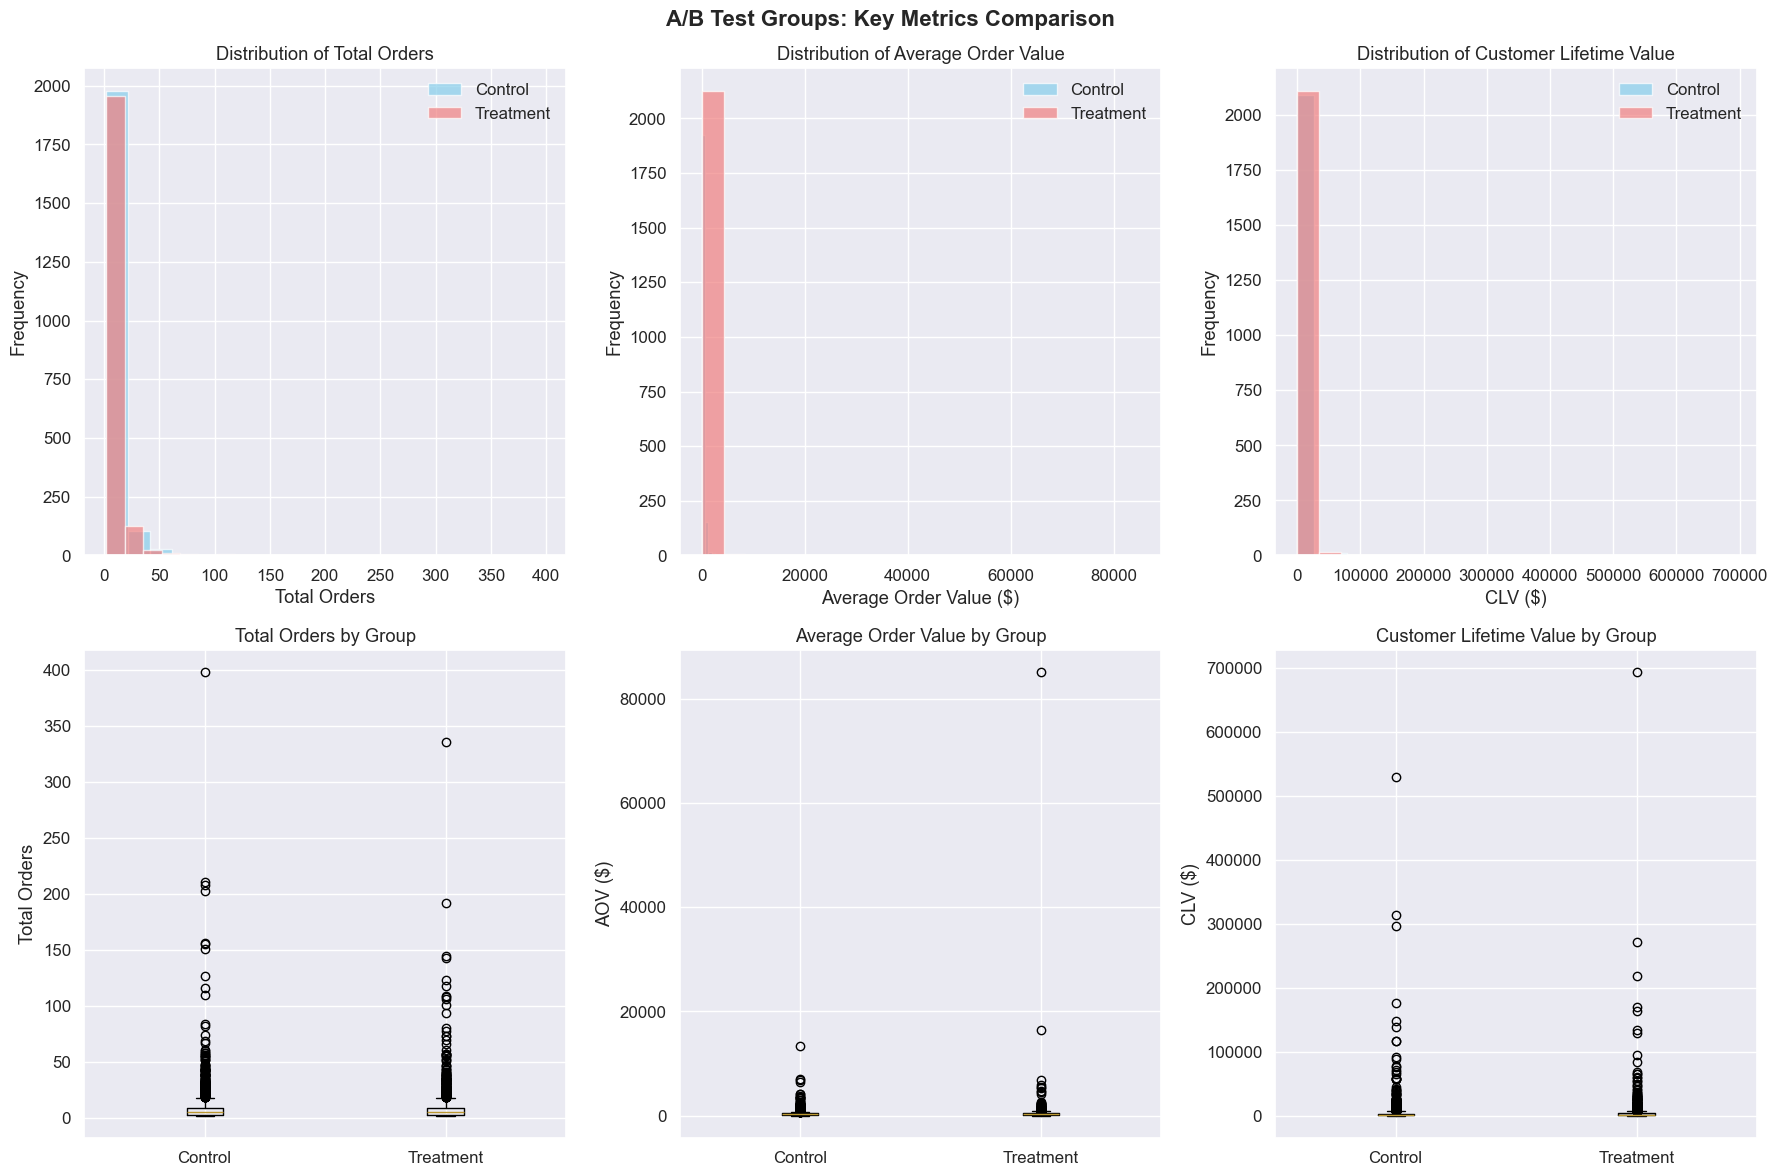


📈 Summary Statistics by Group:
          total_orders               avg_order_value                   \
                  mean    std median            mean      std  median   
group                                                                   
control           8.57  15.88    5.0          393.58   516.74  297.62   
treatment         8.34  13.65    5.0          453.53  1906.73  326.48   

               clv                     
              mean       std   median  
group                                  
control    4227.80  17485.37  1408.04  
treatment  4290.58  18926.56  1615.45  


In [14]:
# ============================================================================
# SECTION 4: EXPLORATORY DATA ANALYSIS
# ============================================================================

print("\n[STEP 4] Exploratory Data Analysis...")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('A/B Test Groups: Key Metrics Comparison', fontsize=16, fontweight='bold')

# 1. Orders distribution
axes[0,0].hist(control_customers['total_orders'], alpha=0.7, label='Control', bins=20, color='skyblue')
axes[0,0].hist(treatment_customers['total_orders'], alpha=0.7, label='Treatment', bins=20, color='lightcoral')
axes[0,0].set_title('Distribution of Total Orders')
axes[0,0].set_xlabel('Total Orders')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 2. AOV distribution
axes[0,1].hist(control_customers['avg_order_value'], alpha=0.7, label='Control', bins=20, color='skyblue')
axes[0,1].hist(treatment_customers['avg_order_value'], alpha=0.7, label='Treatment', bins=20, color='lightcoral')
axes[0,1].set_title('Distribution of Average Order Value')
axes[0,1].set_xlabel('Average Order Value ($)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# 3. CLV distribution
axes[0,2].hist(control_customers['clv'], alpha=0.7, label='Control', bins=20, color='skyblue')
axes[0,2].hist(treatment_customers['clv'], alpha=0.7, label='Treatment', bins=20, color='lightcoral')
axes[0,2].set_title('Distribution of Customer Lifetime Value')
axes[0,2].set_xlabel('CLV ($)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].legend()

# 4. Box plots for orders
box_data_orders = [control_customers['total_orders'], treatment_customers['total_orders']]
axes[1,0].boxplot(box_data_orders, labels=['Control', 'Treatment'])
axes[1,0].set_title('Total Orders by Group')
axes[1,0].set_ylabel('Total Orders')

# 5. Box plots for AOV
box_data_aov = [control_customers['avg_order_value'], treatment_customers['avg_order_value']]
axes[1,1].boxplot(box_data_aov, labels=['Control', 'Treatment'])
axes[1,1].set_title('Average Order Value by Group')
axes[1,1].set_ylabel('AOV ($)')

# 6. Box plots for CLV
box_data_clv = [control_customers['clv'], treatment_customers['clv']]
axes[1,2].boxplot(box_data_clv, labels=['Control', 'Treatment'])
axes[1,2].set_title('Customer Lifetime Value by Group')
axes[1,2].set_ylabel('CLV ($)')

plt.tight_layout()
plt.show()

# Summary statistics
summary_stats = test_data.groupby('group')[['total_orders', 'avg_order_value', 'clv']].agg(['mean', 'std', 'median']).round(2)
print("\n📈 Summary Statistics by Group:")
print(summary_stats)

In [15]:
# ============================================================================
# SECTION 5: HYPOTHESIS TESTING
# ============================================================================

print("\n[STEP 5] Statistical Hypothesis Testing...")

def perform_ab_test(control_data, treatment_data, metric_name, alpha=0.05):
    """
    Perform comprehensive A/B test analysis for a given metric
    """
    print(f"\n🔬 A/B Test Results for {metric_name}:")
    print("="*50)
    
    # Descriptive statistics
    control_mean = np.mean(control_data)
    treatment_mean = np.mean(treatment_data)
    control_std = np.std(control_data)
    treatment_std = np.std(treatment_data)
    
    print(f"Control Group    - Mean: {control_mean:.2f}, Std: {control_std:.2f}, n: {len(control_data)}")
    print(f"Treatment Group  - Mean: {treatment_mean:.2f}, Std: {treatment_std:.2f}, n: {len(treatment_data)}")
    
    # Effect size
    absolute_effect = treatment_mean - control_mean
    relative_effect = (absolute_effect / control_mean) * 100
    
    print(f"\nEffect Size:")
    print(f"• Absolute Effect: {absolute_effect:.2f}")
    print(f"• Relative Effect: {relative_effect:.1f}%")
    
    # Statistical tests
    # 1. Welch's t-test (unequal variances)
    t_stat, t_pvalue = ttest_ind(treatment_data, control_data, equal_var=False)
    
    # 2. Mann-Whitney U test (non-parametric)
    u_stat, u_pvalue = mannwhitneyu(treatment_data, control_data, alternative='two-sided')
    
    print(f"\nStatistical Tests:")
    print(f"• Welch's t-test: t={t_stat:.3f}, p-value={t_pvalue:.4f}")
    print(f"• Mann-Whitney U: U={u_stat:.0f}, p-value={u_pvalue:.4f}")
    
    # Confidence interval for difference in means
    pooled_se = np.sqrt((control_std**2/len(control_data)) + (treatment_std**2/len(treatment_data)))
    margin_error = stats.t.ppf(1-alpha/2, len(control_data)+len(treatment_data)-2) * pooled_se
    ci_lower = absolute_effect - margin_error
    ci_upper = absolute_effect + margin_error
    
    print(f"• 95% CI for difference: [{ci_lower:.2f}, {ci_upper:.2f}]")
    
    # Conclusion
    is_significant = t_pvalue < alpha
    print(f"\n📊 Conclusion:")
    print(f"• Result: {'SIGNIFICANT' if is_significant else 'NOT SIGNIFICANT'} at α={alpha}")
    if is_significant:
        direction = "INCREASE" if absolute_effect > 0 else "DECREASE"
        print(f"• The treatment shows a significant {direction} of {abs(relative_effect):.1f}%")
    
    return {
        'metric': metric_name,
        'control_mean': control_mean,
        'treatment_mean': treatment_mean,
        'absolute_effect': absolute_effect,
        'relative_effect': relative_effect,
        'p_value': t_pvalue,
        'is_significant': is_significant,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

# Test 1: Total Orders (Proxy for Conversion Rate)
orders_results = perform_ab_test(
    control_customers['total_orders'], 
    treatment_customers['total_orders'], 
    'Total Orders'
)

# Test 2: Average Order Value
aov_results = perform_ab_test(
    control_customers['avg_order_value'], 
    treatment_customers['avg_order_value'], 
    'Average Order Value ($)'
)

# Test 3: Customer Lifetime Value
clv_results = perform_ab_test(
    control_customers['clv'], 
    treatment_customers['clv'], 
    'Customer Lifetime Value ($)'
)


[STEP 5] Statistical Hypothesis Testing...

🔬 A/B Test Results for Total Orders:
Control Group    - Mean: 8.57, Std: 15.87, n: 2122
Treatment Group  - Mean: 8.34, Std: 13.65, n: 2133

Effect Size:
• Absolute Effect: -0.23
• Relative Effect: -2.7%

Statistical Tests:
• Welch's t-test: t=-0.515, p-value=0.6069
• Mann-Whitney U: U=2332988, p-value=0.0790
• 95% CI for difference: [-1.12, 0.66]

📊 Conclusion:
• Result: NOT SIGNIFICANT at α=0.05

🔬 A/B Test Results for Average Order Value ($):
Control Group    - Mean: 393.58, Std: 516.62, n: 2122
Treatment Group  - Mean: 453.53, Std: 1906.28, n: 2133

Effect Size:
• Absolute Effect: 59.95
• Relative Effect: 15.2%

Statistical Tests:
• Welch's t-test: t=1.401, p-value=0.1613
• Mann-Whitney U: U=2471873, p-value=0.0000
• 95% CI for difference: [-23.91, 143.80]

📊 Conclusion:
• Result: NOT SIGNIFICANT at α=0.05

🔬 A/B Test Results for Customer Lifetime Value ($):
Control Group    - Mean: 4227.80, Std: 17481.24, n: 2122
Treatment Group  - Mean:


[STEP 6] Business Impact Analysis...
💰 Business Impact Projections:
Current Test Results:
• Control Revenue/Customer: $4227.80
• Treatment Revenue/Customer: $4290.58
• Revenue Lift per Customer: $62.78

Annual Projections (assuming 50,000 customers):
• Projected Annual Revenue Lift: $3,138,826.31
• ROI from Free Shipping: 1.5%

Cost Sensitivity Analysis:
• Assumed shipping cost per order: $8.5
• Shipping cost per treatment customer: $70.90
• Net revenue lift per customer: $-8.12
• Net annual impact: $-406,227.61

[STEP 7] Results Visualization...


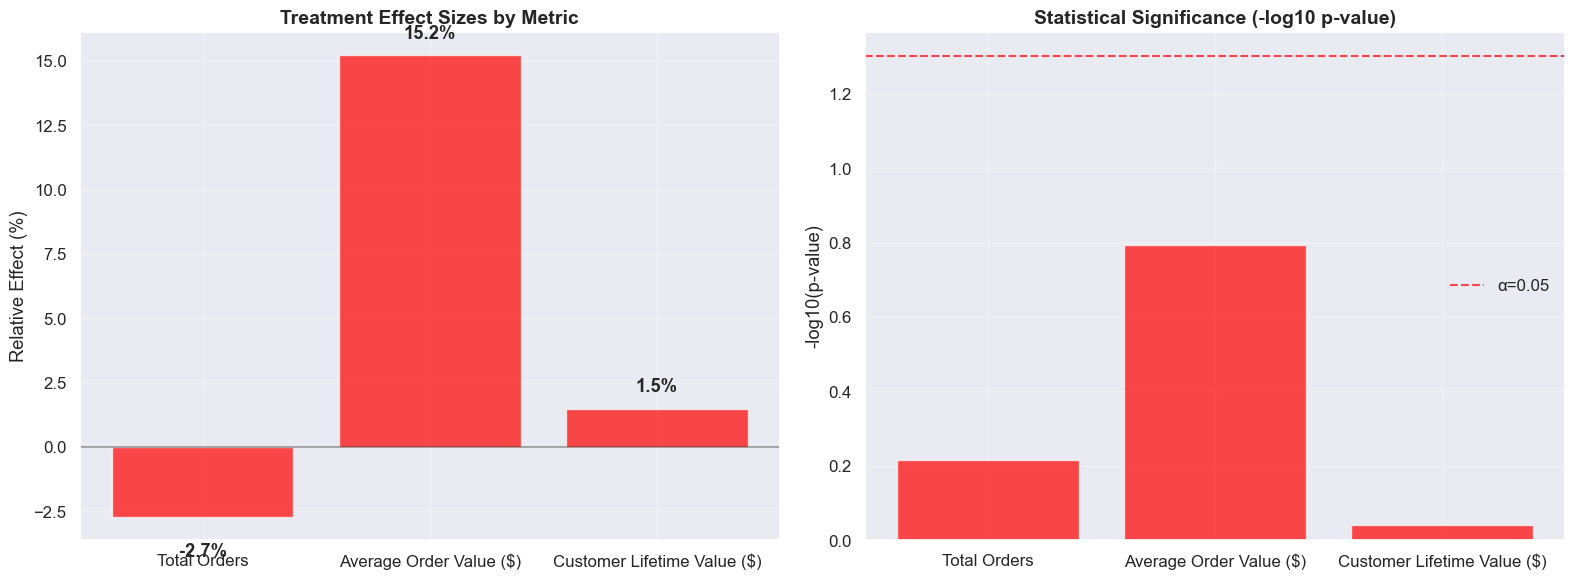

In [16]:
# ============================================================================
# SECTION 6: BUSINESS IMPACT ANALYSIS
# ============================================================================

print("\n[STEP 6] Business Impact Analysis...")

# Calculate business metrics
total_customers = len(test_data)
revenue_control = control_customers['total_revenue'].sum()
revenue_treatment = treatment_customers['total_revenue'].sum()

# Projected annual impact
annual_customers = 50000  # Assumed annual customer base
control_revenue_per_customer = control_customers['total_revenue'].mean()
treatment_revenue_per_customer = treatment_customers['total_revenue'].mean()

annual_revenue_lift = annual_customers * (treatment_revenue_per_customer - control_revenue_per_customer)
roi_percentage = ((treatment_revenue_per_customer - control_revenue_per_customer) / control_revenue_per_customer) * 100

print(f"💰 Business Impact Projections:")
print(f"="*50)
print(f"Current Test Results:")
print(f"• Control Revenue/Customer: ${control_revenue_per_customer:.2f}")
print(f"• Treatment Revenue/Customer: ${treatment_revenue_per_customer:.2f}")
print(f"• Revenue Lift per Customer: ${treatment_revenue_per_customer - control_revenue_per_customer:.2f}")

print(f"\nAnnual Projections (assuming {annual_customers:,} customers):")
print(f"• Projected Annual Revenue Lift: ${annual_revenue_lift:,.2f}")
print(f"• ROI from Free Shipping: {roi_percentage:.1f}%")

# Sensitivity analysis
shipping_cost_per_order = 8.50  # Assumed average shipping cost
treatment_avg_orders = treatment_customers['total_orders'].mean()
shipping_cost_per_customer = shipping_cost_per_order * treatment_avg_orders
net_revenue_lift = (treatment_revenue_per_customer - control_revenue_per_customer) - shipping_cost_per_customer

print(f"\nCost Sensitivity Analysis:")
print(f"• Assumed shipping cost per order: ${shipping_cost_per_order}")
print(f"• Shipping cost per treatment customer: ${shipping_cost_per_customer:.2f}")
print(f"• Net revenue lift per customer: ${net_revenue_lift:.2f}")
print(f"• Net annual impact: ${annual_customers * net_revenue_lift:,.2f}")

# ============================================================================
# SECTION 7: RESULTS VISUALIZATION
# ============================================================================

print("\n[STEP 7] Results Visualization...")

# Create results summary visualization
results_data = [orders_results, aov_results, clv_results]
metrics = [r['metric'] for r in results_data]
effects = [r['relative_effect'] for r in results_data]
p_values = [r['p_value'] for r in results_data]
significance = [r['is_significant'] for r in results_data]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Effect sizes
colors = ['green' if sig else 'red' for sig in significance]
bars = ax1.bar(metrics, effects, color=colors, alpha=0.7)
ax1.set_title('Treatment Effect Sizes by Metric', fontsize=14, fontweight='bold')
ax1.set_ylabel('Relative Effect (%)')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, effect in zip(bars, effects):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -1),
             f'{effect:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

# P-values
ax2.bar(metrics, [-np.log10(p) for p in p_values], color=colors, alpha=0.7)
ax2.set_title('Statistical Significance (-log10 p-value)', fontsize=14, fontweight='bold')
ax2.set_ylabel('-log10(p-value)')
ax2.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='α=0.05')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [17]:
# ============================================================================
# SECTION 8: CONCLUSIONS AND RECOMMENDATIONS
# ============================================================================

print("\n[STEP 8] Conclusions and Recommendations...")
print("="*70)

print(f"\n🎯 KEY FINDINGS:")
significant_metrics = [r['metric'] for r in results_data if r['is_significant']]
if significant_metrics:
    print(f"✅ Statistically significant improvements in: {', '.join(significant_metrics)}")
else:
    print("❌ No statistically significant improvements detected")

print(f"\n📊 QUANTITATIVE RESULTS:")
for result in results_data:
    status = "✅" if result['is_significant'] else "❌"
    print(f"{status} {result['metric']}: {result['relative_effect']:+.1f}% change (p={result['p_value']:.4f})")

print(f"\n💡 BUSINESS RECOMMENDATIONS:")

if any(r['is_significant'] for r in results_data):
    print(f"1. IMPLEMENT FREE SHIPPING: The test shows significant positive impact")
    print(f"2. SCALE GRADUALLY: Start with high-value customer segments")
    print(f"3. MONITOR COSTS: Track shipping expenses vs. revenue gains")
    print(f"4. OPTIMIZE THRESHOLD: Consider minimum order value for free shipping")
else:
    print(f"1. EXTEND TEST DURATION: Current results inconclusive")
    print(f"2. INCREASE SAMPLE SIZE: Improve statistical power")
    print(f"3. SEGMENT ANALYSIS: Test may work for specific customer groups")
    print(f"4. ALTERNATIVE STRATEGIES: Consider other conversion optimization tactics")

print(f"\n⚠️  LIMITATIONS & CONSIDERATIONS:")
print(f"• Sample size: {len(test_data):,} customers")
print(f"• Test duration: Simulated {TEST_DURATION_DAYS}-day test")
print(f"• Seasonality: Consider seasonal shopping patterns")
print(f"• Competition: Monitor competitor pricing and shipping policies")
print(f"• Long-term effects: Track customer behavior beyond initial test period")

print(f"\n🔄 NEXT STEPS:")
print(f"1. Present findings to stakeholders")
print(f"2. Develop implementation timeline")
print(f"3. Set up monitoring dashboard")
print(f"4. Plan follow-up analysis")

print("\n" + "="*70)
print("ANALYSIS COMPLETED SUCCESSFULLY".center(70))
print(f"Generated by: Wu Yao | Date: {datetime.now().strftime('%Y-%m-%d')}".center(70))
print("="*70)

# Export results summary
results_summary = pd.DataFrame([
    {
        'Metric': r['metric'],
        'Control_Mean': r['control_mean'],
        'Treatment_Mean': r['treatment_mean'],
        'Absolute_Effect': r['absolute_effect'],
        'Relative_Effect_Pct': r['relative_effect'],
        'P_Value': r['p_value'],
        'Significant': r['is_significant'],
        'CI_Lower': r['ci_lower'],
        'CI_Upper': r['ci_upper']
    } for r in results_data
])

print(f"\n📋 FINAL RESULTS SUMMARY:")
print(results_summary.to_string(index=False, float_format='%.3f'))

# Save results
# results_summary.to_csv('ab_test_results_summary.csv', index=False)
# print(f"\n✅ Results exported to 'ab_test_results_summary.csv'")


[STEP 8] Conclusions and Recommendations...

🎯 KEY FINDINGS:
❌ No statistically significant improvements detected

📊 QUANTITATIVE RESULTS:
❌ Total Orders: -2.7% change (p=0.6069)
❌ Average Order Value ($): +15.2% change (p=0.1613)
❌ Customer Lifetime Value ($): +1.5% change (p=0.9105)

💡 BUSINESS RECOMMENDATIONS:
1. EXTEND TEST DURATION: Current results inconclusive
2. INCREASE SAMPLE SIZE: Improve statistical power
3. SEGMENT ANALYSIS: Test may work for specific customer groups
4. ALTERNATIVE STRATEGIES: Consider other conversion optimization tactics

⚠️  LIMITATIONS & CONSIDERATIONS:
• Sample size: 4,255 customers
• Test duration: Simulated 21-day test
• Seasonality: Consider seasonal shopping patterns
• Competition: Monitor competitor pricing and shipping policies
• Long-term effects: Track customer behavior beyond initial test period

🔄 NEXT STEPS:
1. Present findings to stakeholders
2. Develop implementation timeline
3. Set up monitoring dashboard
4. Plan follow-up analysis

    